In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from snsphd import viz
import math
import orjson
Colors, pallet = viz.phd_style(jupyterStyle = True, grid = True, axese_width=0.5, text = 6, svg_mode=True)

from enum import Enum
from dataclasses import dataclass, fields, field, _MISSING_TYPE 

from load_schema import Decode, Result

import matplotlib as mpl
import os

# set the DPI for all figures
mpl.rcParams['figure.dpi'] = 100

from snsphd.layout import bisect

from numba import njit
from snsphd.viz import save_bokeh_dark_json

In [3]:
with open("../inter/decode_20GHz26.0.json", "r") as f:
    data = orjson.loads(f.read())
    decode = Decode(**data)

db_values = np.arange(16,50, 2).tolist()
print(db_values)

# need type hints for intellisense to work
def decode_from_folder(folder_path: str, db_values: list[int]) -> list[Decode]:
    decodes = []
    for db in db_values:
        filename = f"decode_20GHz{db}.0.json"
        filepath = os.path.join(folder_path, filename)
        with open(filepath, "r") as f:
            data = orjson.loads(f.read())
            decode = Decode(**data)
            decodes.append(decode)
    return decodes

decodes = decode_from_folder("../inter", db_values)

[16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]


In [4]:
@njit
def gaussian_2d(x, y, cov, pos=np.array([0, 0])):
    """Generate a 2D Gaussian distribution with a given covariance matrix and position."""
    # Unpack the position tuple
    x0, y0 = pos

    # Shift the coordinates by x0 and y0
    x = x - x0
    y = y - y0

    # Calculate the inverse of the covariance matrix
    inv_cov = np.linalg.inv(cov)

    # Calculate the determinant of the covariance matrix
    det_cov = np.linalg.det(cov)

    # Calculate the exponent term of the Gaussian function
    exponent = -0.5 * (
        inv_cov[0, 0] * np.square(x)
        + (inv_cov[0, 1] + inv_cov[1, 0]) * x * y
        + inv_cov[1, 1] * np.square(y)
    )

    # Calculate the normalization constant of the Gaussian function
    norm_const = 1 / (2 * np.pi * np.sqrt(det_cov))

    # Calculate the Gaussian function values
    gauss = norm_const * np.exp(exponent)

    return gauss


# @njit
def find_gm_prob_for_offset(
    x,
    y,
    existing_z,
    offset_idx,
    gm_means,
    gm_covar,
    gm_weights,
):
    """given the gaussian mixture model for the distribution of counts
    at a given offset index, find the probability of the count originating
    from the time slot with this offset. The offset index is a number of
    bins, (probably 50 ps wide)
    """
    # x = xy[0]
    # y = xy[1]
    # z = 0

    offset = offset_idx

    for pos, covar, w in zip(gm_means, gm_covar, gm_weights):
        existing_z = existing_z + gaussian_2d(x, y, covar, np.array([pos[0] + offset*50, pos[1]+ offset*50])) * w

    return existing_z

number of components: 17
(1999, 1999)


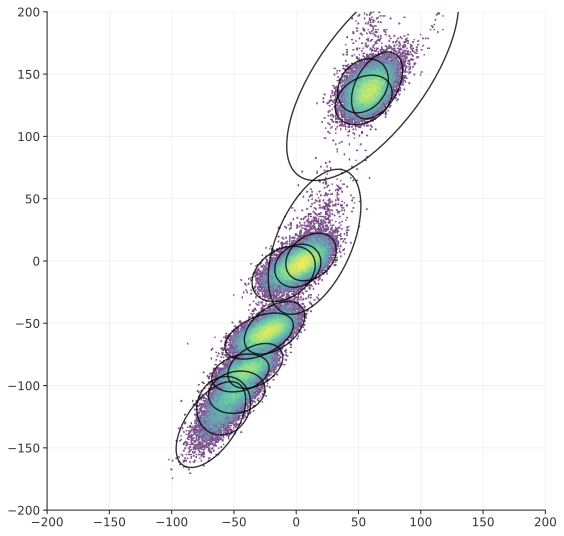

In [5]:
from matplotlib.patches import Ellipse
from load_schema import GMData
import copy
import matplotlib

def draw_ellipse(position, covariance, ax=None, single_ellipse=False, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    if single_ellipse:
        nsig = 3
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                                angle=angle, fill=False, edgecolor='black', **kwargs))
    else:
        for nsig in np.linspace(0,4, 8):
            ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                                angle=angle, fill=False, edgecolor='black', **kwargs))
        
    
        

def plot_gmm(ax, gm_data: GMData, label=True, data_alpha=0.2, single_ellipse=False, **ellipse_kwargs):

    w_factor = 0.2 / gm_data.weights.max()
    for pos, covar, w in zip(gm_data.means, gm_data.covariances, gm_data.weights):
        draw_ellipse(pos, covar, ax=ax, single_ellipse=single_ellipse, **ellipse_kwargs)






def plot_data_and_ellipses(ax, struct, dbidx, comp_idx, offset_x=0, offset_y=0, scale_down=2, data_alpha=0.7):

    bins = struct[dbidx].hist_data.bins

    bins = np.mean(bins.reshape(-1, scale_down), axis=1)

    x = struct[dbidx].hist_data.counts[:,0]
    y = struct[dbidx].hist_data.counts[:,1]
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=bins)
    # Create a grid of x and y coordinates
    x_grid, y_grid = np.meshgrid(x_edges[:-1], y_edges[:-1])

    # Calculate the center of mass
    y_com = np.sum(x_grid * hist) / np.sum(hist)
    x_com = np.sum(y_grid * hist) / np.sum(hist)

    gm_data_current = copy.deepcopy(struct[dbidx].gm_data.gm_list[comp_idx])


    print(f"number of components: {gm_data_current.num_components}")

    gm_data_current.means[:,0] -= (x_com + offset_x)
    gm_data_current.means[:,1] -= (y_com + offset_y)


    plot_gmm(ax, gm_data_current, single_ellipse=True, lw=1.4, alpha=0.8)
    print(np.shape(hist))

    # _ = ax.hist2d(x-x_com, y-y_com, bins=bins, norm=matplotlib.colors.LogNorm(), alpha=0.5, density=True, rasterized=True)

    hist, xbins, ybins = np.histogram2d(x-(x_com+offset_x), y-(y_com+offset_y), bins=bins, density=False)
    hist = hist - 0.15
    norm = matplotlib.colors.LogNorm()
    ax.imshow(hist.T, origin='lower', extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='viridis', norm=norm, alpha=data_alpha, rasterized=True)


    ax.set_ylim(-200, 200)
    ax.set_xlim(-200, 200)


dB_idx = 5
components_idx = 6
fig, ax = plt.subplots(1,1, figsize=(9,9))
plot_data_and_ellipses(ax, decodes, dB_idx, components_idx, scale_down=1)

(-220.0, 220.0)

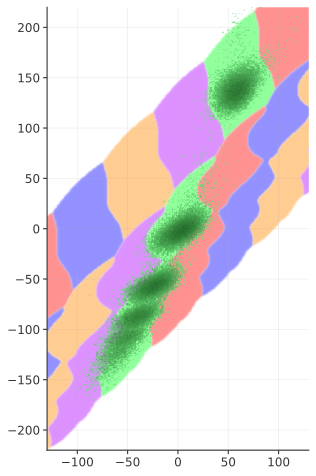

In [7]:
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap



def find_bins(ax, struct, dbidx, comp_idx):

    gm_data_current = copy.deepcopy(struct[dbidx].gm_data.gm_list[comp_idx])
    # xbins = struct[dbidx].hist_data.bins
    # ybins = struct[dbidx].hist_data.bins

    bins = struct[dbidx].hist_data.bins
    # bins = np.mean(bins.reshape(-1, 2), axis=1)



    xbins = bins
    ybins = bins

    x = struct[dbidx].hist_data.counts[:,0]
    y = struct[dbidx].hist_data.counts[:,1]
    xx, yy = np.meshgrid(xbins[:-1], ybins[:-1])
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=bins)
    y_com = np.sum(xx * hist) / np.sum(hist)
    x_com = np.sum(yy * hist) / np.sum(hist)

    cmap = matplotlib.colormaps['jet']
    nm = plt.Normalize(vmin=0, vmax=1)
    
    levels = np.linspace(0.001, 1, 10)

    res_idxs = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    # cmaps = ["Reds", "Blues", "Oranges", "Purples", "Greens", "Reds", "Blues", "Oranges", "Purples"]


    ress = []
    colors = ["red", "blue", "orange", "purple", "green", "red", "blue", "orange", "purple"]
    nice_hex_colors = ['#FF9191', '#9391FF', '#FFCC91', '#DC91FF', '#91FF9C', '#FF9191', '#9391FF', '#FFCC91', '#DC91FF']
    for i, res_idx in enumerate(res_idxs):
        rs = find_gm_prob_for_offset(xx+x_com, yy-y_com, 0, res_idx, gm_data_current.means, gm_data_current.covariances, gm_data_current.weights)
        rs = np.abs(rs/np.max(rs))
        ress.append(rs)
        

    prob_stack_3d = np.stack(ress, axis=2)
    prob_order = np.argmax(prob_stack_3d, axis=2)

    sorted = np.sort(prob_stack_3d, axis=2)

    where_similar = (sorted[:,:,-1] - sorted[:,:,-2]) < .0002

    where_not_small = (np.max(prob_stack_3d, axis=2) >= .0002)



    for i in range(np.shape(prob_stack_3d)[2]):
        # cmap = ListedColormap([colors[i], colors[i]])
        cmap = ListedColormap([nice_hex_colors[i], nice_hex_colors[i]])


        bin = (where_not_small & (prob_order==i)).astype(np.uint8)
        blurred_bin = gaussian_filter(bin*255, sigma=0.7)/256

        ax.imshow((prob_order==i).astype(np.uint8), alpha = blurred_bin, origin='lower', extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap=cmap, rasterized=True)

    # ax.imshow(where_similar.astype(np.uint8), alpha = 0.2*where_similar.astype(np.uint8), origin='lower', extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap='binary', rasterized=True)


    my_colors = ["#69db75", "#07450d"]
    cmap = LinearSegmentedColormap.from_list('my_cmap', my_colors)
    ax.hist2d(x-x_com, y-y_com, bins=bins, norm=matplotlib.colors.LogNorm(), alpha=0.8, density=True, cmap=cmap, rasterized=True)

    return prob_stack_3d, prob_order

dB_idx = 5
components_idx = 6
aspect_ratio = 1
fig, ax = plt.subplots(1,1, figsize=(8,aspect_ratio*8))
prob_stack_3d, prob_order = find_bins(ax, decodes, dB_idx, components_idx)
# ax.set_ylim(-250,250)
# ax.set_xlim(-250,250)

ax.set_xlim(-130,130)
ax.set_ylim(-220,220)

(-250.0, 250.0)

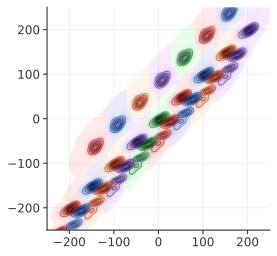

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize


# I want to crop the xbins and ybins




y_start = -140
y_end = 170
x_start = -70
x_end = 110

aspect_ratio = (y_end - y_start)/(x_end - x_start)


def plot_model_contour(ax, struct, dbidx, comp_idx):

    gm_data_current = copy.deepcopy(struct[dbidx].gm_data.gm_list[comp_idx])
    # xbins = struct[dbidx].hist_data.bins
    # ybins = struct[dbidx].hist_data.bins

    bins = struct[dbidx].hist_data.bins
    # bins = np.mean(bins.reshape(-1, 2), axis=1)



    xbins = bins
    ybins = bins

    x = struct[dbidx].hist_data.counts[:,0]
    y = struct[dbidx].hist_data.counts[:,1]
    xx, yy = np.meshgrid(xbins[:-1], ybins[:-1])
    hist, x_edges, y_edges = np.histogram2d(x, y, bins=bins)
    y_com = np.sum(xx * hist) / np.sum(hist)
    x_com = np.sum(yy * hist) / np.sum(hist)

    cmap = matplotlib.colormaps['jet']
    nm = plt.Normalize(vmin=0, vmax=1)
    
    levels = np.linspace(0.001, 1, 10)

    res_idxs = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    cmaps = ["Reds", "Blues", "Oranges", "Purples", "Greens", "Reds", "Blues", "Oranges", "Purples"]


    ress = []
    for i, res_idx in enumerate(res_idxs):
        rs = find_gm_prob_for_offset(xx+x_com, yy-y_com, 0, res_idx, gm_data_current.means, gm_data_current.covariances, gm_data_current.weights)

        
        # Get a color from the colormap
        color = cmap(nm((i+1)/len(res_idxs)))
        # print(color)
        hex_color = colors.to_hex(color)
    
        
        rs = np.abs(rs/np.max(rs)) + .00001 # so the log plotting won't complain
        norm = matplotlib.colors.LogNorm(vmin=.001*np.max(rs), vmax=1)

        cmap = plt.get_cmap(cmaps[i])


        # Get a list of RGB values from the Viridis colormap
        rgb_values = cmap(nm(np.linspace(0, 1, 256)))[:, :3]

        # Brighten the RGB values
        bright_rgb_values = np.clip(rgb_values**2, 0, 1)
        hex_rgb = [colors.to_hex(rgb_value) for rgb_value in rgb_values]
        bright_cmap = colors.ListedColormap(bright_rgb_values)

        cmap_single_color = LinearSegmentedColormap.from_list("", [hex_rgb[230], hex_rgb[230]])
        ax.contour(rs, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap=bright_cmap, norm=norm, alpha=0.6, levels=levels[1:], linewidths=1.0)
        alphas = Normalize(0, 1, clip=True)(np.abs(rs))
        ax.imshow(rs, alpha=alphas**0.8, origin='lower', extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap=cmap_single_color, norm=norm)
        ress.append(rs)

    
    # show bins
    ################################################
    prob_stack_3d = np.stack(ress, axis=2)
    prob_order = np.argmax(prob_stack_3d, axis=2)

    sorted = np.sort(prob_stack_3d, axis=2)

    where_similar = (sorted[:,:,-1] - sorted[:,:,-2]) < .0002

    where_not_small = (np.max(prob_stack_3d, axis=2) >= .0002)


    nice_hex_colors = ['#FF9191', '#9391FF', '#FFCC91', '#DC91FF', '#91FF9C', '#FF9191', '#9391FF', '#FFCC91', '#DC91FF']
    for i in range(np.shape(prob_stack_3d)[2]):
        # cmap = ListedColormap([colors[i], colors[i]])
        cmap = ListedColormap([nice_hex_colors[i], nice_hex_colors[i]])


        bin = (where_not_small & (prob_order==i)).astype(np.uint8)
        blurred_bin = gaussian_filter(bin*255, sigma=0.2)/256

        ax.imshow((prob_order==i).astype(np.uint8), alpha = 0.2*blurred_bin, origin='lower', extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], cmap=cmap, rasterized=True)
    # rs_sum = np.sum(ress, axis=0)
    return [plt.get_cmap(cmap)(0.9) for cmap in cmaps], ress


fig, ax = plt.subplots(1,1, figsize=(4,aspect_ratio*4))

cols, ress = plot_model_contour(ax, decodes, dB_idx, components_idx)


ax.set_xlim(-250,250)
ax.set_ylim(-250,250)


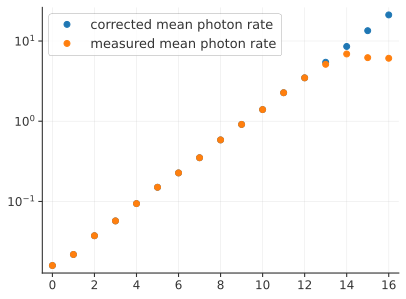

In [9]:

def calculate_mfr(struct: list[Decode]) -> list[float]:
    mfrs = []
    for d in range(len(struct)):
        missing = 0
        found = 0
        for res in struct[d].results[0]:
            result: Result = res.result
            if result == Result.MISSING:
                missing += 1
            if (result == Result.CORRECT) or (result == Result.INCORRECT):
                found += 1
        total = missing + found

        ratio_of_vacuum = missing/total
        mfr = -np.log(ratio_of_vacuum)
        mfrs.append(mfr)

    return mfrs

mfr = calculate_mfr(decodes)

mfr = np.flip(mfr)
# plt.plot(mfr)

ln_mfr = np.log(mfr)
x = np.arange(len(ln_mfr))
slope, intercept = np.polyfit(x[:-3], ln_mfr[:-3], 1)
ln_mfr_ext = slope*x + intercept


# plt.plot(x, ln_mfr, 'o')
# plt.plot(x, ln_mfr_ext, 'o')

ln_mfr_corrected = ln_mfr.copy()
ln_mfr_corrected[-4:] = ln_mfr_ext[-4:]
mfr_corrected = np.exp(ln_mfr_corrected)



plt.plot(x, mfr_corrected, 'o', label="corrected mean photon rate")
plt.plot(x, mfr, 'o', label="measured mean photon rate")
plt.yscale('log')
plt.legend()

# put the order back to what it was
mfr = np.flip(mfr)
mfr_corrected = np.flip(mfr_corrected)

In [10]:
decodes[dB_idx+5].gm_data.gm_list[components_idx-5].num_components

7

In [11]:

from snsphd.layout import bisect
import time
warnings.filterwarnings("always", category=UserWarning)
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

fig, axs = plt.subplots(1,3, figsize=(14,7))

dB_idx = 5
components_idx = 6
plot_data_and_ellipses(axs[0], decodes, dB_idx+5, components_idx-5, offset_x=-30, offset_y=-45, scale_down=1, data_alpha=0.5)



abc_label_offs_left = -.18
abc_label_offs_top = 1.02


axs[0].set_xlim(-130,130)
axs[0].set_ylim(-220,220)
axs[0].set_xlabel(r"$t_A$ (ps)")
axs[0].set_ylabel(r"$t_B$ (ps)")
axs[0].text(-10, 25, r'$\bm{|1\rangle}$', ha='center', va='center', fontsize=14, color='k', transform=axs[0].transData, usetex=True)
axs[0].text(-50, -65, r'$\bm{|2\rangle}$', ha='center', va='center', fontsize=14, color='k', transform=axs[0].transData, usetex=True)
axs[0].text(-88, -125, r'$\bm{|3+\rangle}$', ha='center', va='center', fontsize=14, color='k', transform=axs[0].transData, usetex=True)

axs[0].text(abc_label_offs_left, abc_label_offs_top, "a)", transform=axs[0].transAxes, fontsize=19, va='top')

component_number = decodes[dB_idx+5].gm_data.gm_list[components_idx-5].num_components
axs[0].text(-120,215, rf"$\bm{{components: {component_number}}}$", ha='left', va='center', fontsize=16, color='k', transform=axs[0].transData, usetex=True)
axs[0].text(-120,188, rf"$\bm{{\mu = {round(mfr_corrected[dB_idx+5],2)}}}$", ha='left', va='center', fontsize=16, color='k', transform=axs[0].transData, usetex=True)




plot_data_and_ellipses(axs[1], decodes, dB_idx, components_idx+1, scale_down=1, data_alpha=0.5)
axs[1].set_xlabel(r"$t_A$ (ps)")
axs[1].set_xlim(-130,130)
axs[1].set_ylim(-220,220)
axs[1].text(9, 118, r'$\bm{|1\rangle}$', ha='center', va='center', fontsize=14, color='k', transform=axs[1].transData, usetex=True)
axs[1].text(-50, 0, r'$\bm{|2\rangle}$', ha='center', va='center', fontsize=14, color='k', transform=axs[1].transData, usetex=True)
axs[1].text(-88, -88, r'$\bm{|3+\rangle}$', ha='center', va='center', fontsize=14, color='k', transform=axs[1].transData, usetex=True)
axs[1].text(abc_label_offs_left, abc_label_offs_top, "b)", transform=axs[1].transAxes, fontsize=19, va='top') 
# axs[1].text(-75,175, rf"$\bm{{\mu = {round(mfr_corrected[dB_idx],2)}}}$", ha='center', va='center', fontsize=16, color='k', transform=axs[1].transData, usetex=True)

component_number = decodes[dB_idx].gm_data.gm_list[components_idx+1].num_components
axs[1].text(-120,215, rf"$\bm{{components: {component_number}}}$", ha='left', va='center', fontsize=16, color='k', transform=axs[1].transData, usetex=True)
axs[1].text(-120,188, rf"$\bm{{\mu = {round(mfr_corrected[dB_idx],2)}}}$", ha='left', va='center', fontsize=16, color='k', transform=axs[1].transData, usetex=True)

plot_contours = True
if plot_contours:
    label_colors, _ = plot_model_contour(axs[2], decodes, dB_idx, components_idx)

    axs[2].text(-45-1*50, 65-1*50, r"$\bm{i-2}$", ha='center', va='center', fontsize=14, color=label_colors[1], transform=axs[2].transData, usetex=True)

    axs[2].text(-45, 65, r"$\bm{i-1}$", ha='center', va='center', fontsize=14, color=label_colors[2], transform=axs[2].transData, usetex=True)

    axs[2].text(-45+1*50, 65+1*50, r"$\bm{i}$", ha='center', va='center', fontsize=14, color=label_colors[3], transform=axs[2].transData, usetex=True)
    axs[2].text(-45+2*50, 65+2*50, r"$\bm{i+1}$", ha='center', va='center', fontsize=14, color=label_colors[4], transform=axs[2].transData, usetex=True)
    axs[2].text(-45+3*50, 65+3*50, r"$\bm{i+2}$", ha='center', va='center', fontsize=14, color=label_colors[5], transform=axs[2].transData, usetex=True)
    axs[2].set_xlabel(r"$t_A$ (ps)")
    axs[2].set_xlim(-130,130)
    axs[2].set_ylim(-220,220)
    axs[2].set_aspect('equal')
    axs[2].text(abc_label_offs_left, abc_label_offs_top, "c)", transform=axs[2].transAxes, fontsize=19, va='top') 

viz.save_light_dark_all(fig, "../figs/gmm_intro_analysis_t", override_cmap=True)


number of components: 7
(1999, 1999)
number of components: 19
(1999, 1999)


In [ ]:
# you are making a 2d array
# maybe it's best to plot multiple imshow()s over each other. 

# you you need a different 2d array for each mask.

# each array solves the question (what is bigger? This current distribution, or all the ones around me?)


#or.... for each point, the objective is to choose the largest distribution. And that tells you what array to increment at that pixel

# okay so you have 9 or so arrays. 

# for each pixel, you solve all 9 distributions. That gives you a list of amplitudes length 9. Then do an argmax() on that, and increment that pixel location for that array.

In [1]:
decodes[0].results

NameError: name 'decodes' is not defined

In [ ]:
class Arr:
    def __init__(self):
        self.x_correct = []
        self.y_correct = []
        self.x_incorrect = []
        self.y_incorrect = []
        self.x_gaussian_fixed = []
        self.y_gaussian_fixed = []
        self.x_gaussian_corrupted = []
        self.y_gaussian_corrupted = []

    def numpyify(self):
        for item in self.__dict__:
            self.__dict__[item] = np.array(self.__dict__[item])


a = Arr()

fig, ax = plt.subplots(1,1, figsize=(16,12))
for stream in decode.results:
    for Event in stream:
        if Event.result == Result.CORRECT:
            a.x_correct.append(Event.tag_x - 50*Event.true)
            a.y_correct.append(Event.tag_y - 50*Event.true)

        if Event.result == Result.INCORRECT:
            a.x_incorrect.append(Event.tag_x - 50*Event.true)
            a.y_incorrect.append(Event.tag_y - 50*Event.true)


        if (Event.gaussian_measured != Event.measured) and (Event.result == Result.CORRECT):
            a.x_gaussian_fixed.append(Event.tag_x - 50*Event.true)
            a.y_gaussian_fixed.append(Event.tag_y - 50*Event.true)

        

        if (Event.true == Event.measured) and (Event.result == Result.INCORRECT):
            a.x_gaussian_corrupted.append(Event.tag_x - 50*Event.true)
            a.y_gaussian_corrupted.append(Event.tag_y - 50*Event.true)

a.numpyify()


ax.scatter(a.x_correct, a.y_correct, s=5, marker='o', color="green", alpha=0.03, rasterized=True)
ax.scatter(a.x_gaussian_fixed, a.y_gaussian_fixed, s=5, marker='o', color='blue', alpha=0.7, rasterized=True)
ax.scatter(a.x_gaussian_corrupted, a.y_gaussian_corrupted, s=5, marker='o', color='red', alpha=0.7, rasterized=True)

ax.scatter(a.x_incorrect, a.y_incorrect, s=5, marker='o', color="darkred", alpha=0.2, rasterized=True)

print((len(a.x_gaussian_fixed) + len(a.x_gaussian_corrupted))/(len(a.x_correct) + len(a.x_incorrect)))



ax.scatter(np.concatenate((a.x_correct, a.x_incorrect)) + 50, np.concatenate((a.y_correct, a.y_incorrect)) + 50, s=5, marker='o', color="black", alpha=0.03, rasterized=True)
ax.scatter(np.concatenate((a.x_correct, a.x_incorrect)) - 50, np.concatenate((a.y_correct, a.y_incorrect)) - 50, s=5, marker='o', color="black", alpha=0.03, rasterized=True)

In [129]:
from numpy.random import standard_normal

from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
# from bokeh.transform import linear_cmap
# from bokeh.util.hex import hexbin
# from bokeh.models import LogColorMapper
from bokeh.models import ColumnDataSource, Rect
# from bokeh.palettes import Sunset8
# from bokeh.colors import RGB
from bokeh.models import WheelZoomTool, PanTool
from bokeh.layouts import column, row
from bokeh.colors import RGB

from bokeh.plotting import figure, output_file, show
from bokeh.models import CustomJS, ColumnDataSource
from bokeh.layouts import column, row
from bokeh.models.widgets import Slider
from bokeh.models.dom import Div, Styles
from bokeh.models import Legend
import numpy as np
import matplotlib as mpl
from snsphd.viz import DarkSlider


cmap = mpl.colormaps['viridis']
cmap = [cmap(i) for i in range(256)] #[::-1]
alpha = np.linspace(.5, 1, 256)
alpha = np.sqrt(alpha)
alpha = np.sqrt(alpha)

cmap = [list(item[:3]) + [alpha[i]] for i, item in enumerate(cmap)]
cmap_alpha = [RGB(int(np.sqrt(color[0])*255), int(np.sqrt(color[1])*255), int(np.sqrt(color[2])*255), color[3]) for color in cmap]
cmap_alpha[0] = RGB(cmap[0][0], cmap[0][1], cmap[0][2], 0)
print(cmap_alpha[1])


# output_notebook()

crop_start = 800
crop_end = 1200

x = decodes[dB_idx].hist_data.counts[:,0]
y = decodes[dB_idx].hist_data.counts[:,1]
bins = decodes[dB_idx].hist_data.bins
xbins = bins
ybins = bins
xx, yy = np.meshgrid(xbins[:-1], ybins[:-1])

hist, x_edges, y_edges = np.histogram2d(x, y, bins=bins)
y_com = np.sum(xx * hist) / np.sum(hist)
x_com = np.sum(yy * hist) / np.sum(hist)
hist, x_edges, y_edges = np.histogram2d(x-x_com, y-y_com, bins=bins)

hist_sm = np.abs(np.copy(5000*hist/np.max(hist))).astype(np.uint16)[crop_start:crop_end, crop_start:crop_end].T

res_idx = 0
gm_data_current = copy.deepcopy(decodes[dB_idx].gm_data.gm_list[16])


rs = find_gm_prob_for_offset(xx+x_com, yy-y_com, 0, res_idx, gm_data_current.means, gm_data_current.covariances, gm_data_current.weights)

res_sm = np.abs(np.copy(5000*rs/np.max(rs))).astype(np.uint16)[crop_start:crop_end, crop_start:crop_end].T


dd_1 = {"image": [hist_sm]}

dd_2 = {"x": np.arange(len(hist_sm)).astype(np.uint16),
      "y_data": np.zeros(len(hist_sm)).astype(np.uint16),
      "y_fit": np.zeros(len(hist_sm)).astype(np.uint16),}

dd_res = {"image": [res_sm.T]}

ds_1 = ColumnDataSource(dd_1)
ds_2 = ColumnDataSource(dd_2)
ds_res = ColumnDataSource(dd_res)

# create a data source for the draggable bar
y_center = np.average([dd_2["x"][0],dd_2["x"][-1]])

# bar_source = ColumnDataSource(data=dict(x=[float(y_center)], y=[dd_2["x"][0]]))
bar_source = ColumnDataSource(data=dict(x=[dd_2["x"][0]], y=[float(y_center)]))
img = figure( match_aspect=True, height=500, width=500, tools=[]) #tools=[WheelZoomTool(), PanTool()])
img.xaxis.axis_label = r"$$t_A\:\mathrm{(ps)}$$"
img.yaxis.axis_label = r"$$t_B\:\mathrm{(ps)}$$"
img.toolbar.logo = None
img.grid.grid_line_color = None
hist_plt_linear = figure(title="", width=250,height=500, toolbar_location=None, y_axis_type='linear', tools=[])
# img.image(image="image", dh=np.shape(hist_sm)[0], dw=np.shape(hist_sm)[1], x=0, y=0, source=dd_1, palette="Spectral11")
img.image(image="image", dh=np.shape(hist_sm)[0], dw=np.shape(hist_sm)[1], x=0, y=0, source=dd_1, palette=cmap_alpha)
# plot the draggable bar

bar = img.rect(x='x', y='y', height=dd_2["x"][-1] - dd_2["x"][0], width=3, alpha=0.5, color='red', source=bar_source)

style = Styles(
    width='100%',
)


styles = Styles(margin = "0px 47px")

# slider = Slider(start=dd_2["x"][0], end=dd_2["x"][-1], step=1, value=0, title="Draggable Range", sizing_mode="stretch_width", styles=styles)
slider = DarkSlider(start=dd_2["x"][0], end=dd_2["x"][-1], step=1, value=0, title="Draggable Range", sizing_mode="stretch_width", styles=styles)
hist_plt_linear.line(x="y_data", y="x", line_width=2, source=ds_2, color="#66a1ff", legend_label="Data")
hist_plt_linear.line(x="y_fit", y="x", line_width=2, source=ds_2, color='#ff6666', legend_label="GMM")

hist_plt_linear.yaxis.axis_label = r"$$\mathrm{dist.\;of}\;t_B\;\mathrm{for\;specific}\;t_A$$"
hist_plt_linear.xaxis.axis_label = r"$$\mathrm{counts\;(a.u.)}$$"

hist_plt_linear.x_range.start = 0
hist_plt_linear.x_range.end = 5000

legend = Legend()#items=[("Data", [hist_plt_linear.renderers[0]]), ("GMM", [hist_plt_linear.renderers[1]])], location="center")
hist_plt_linear.add_layout(legend, "right")

# create a custom JavaScript callback to link the x-location of the bar to the value of the slider
callback = CustomJS(args=dict(bar_source=bar_source, slider=slider, image_source = ds_1, updating_line_source = ds_2, fit_source = ds_res), code=f"""
    var ln_data = updating_line_source.data;
                    
    var data = bar_source.data;
    var image_data = image_source.data;
    var fit_image_data = fit_source.data;
    var range = slider.value;
    data['x'][0] = range;
                    
    //console.log(ln_data['y_data'])
    
    //use the range value as an index
    //line_data['y'] = line_data[range]
    //ln_data['y_data'] = image_data['image'][0][range]
    //console.log(image_data['image'][0])
    //const dimensions = [ image_data['image'].length, image_data['image'][0].length ];
    //console.log(dimensions)
    let image_width = {np.shape(hist_sm)[0]}
    let image_height = {np.shape(hist_sm)[1]}
            
    //let slc = image_data['image'][0].slice(range*image_width, range*image_width + image_width)
    //let slc_fit = fit_image_data['image'][0].slice(range*image_width, range*image_width + image_width)
    let slc = new Uint16Array(image_height)
    let slc_fit = new Uint16Array(image_height)
    for (let i = 0; i < image_height; i++) {{
        slc[i] = image_data['image'][0][i*image_height + range]
        slc_fit[i] = fit_image_data['image'][0][i*image_height + range]
    }}

    //console.log(slc)
    ln_data['y_data'] = slc
    ln_data['y_fit'] = slc_fit

    //console.log(slc_fit)
    
    
    updating_line_source.change.emit();
    bar_source.change.emit();
    //console.log(ln_data['y_data'])
""")

# link the slider to the JavaScript callback
slider.js_on_change('value', callback)

# col = column(children=[hist_plt_linear])
c = column(img, slider)
r = row(c, hist_plt_linear)
# r = row(img, hist_plt_linear)
# c = column(r,slider)
layout = r
# layout = row(c, col)

save_bokeh_dark_json(layout, "pnr_gmm.json", apply=False)

# show the plot
show(layout)

rgba(132, 24, 147, 0.8417196139048182)
